<a href="https://www.kaggle.com/code/brianalvarez/brian-optiver?scriptVersionId=173211426" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/optiver-trading-at-the-close/public_timeseries_testing_util.py
/kaggle/input/optiver-trading-at-the-close/train.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/sample_submission.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/revealed_targets.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv
/kaggle/input/optiver-trading-at-the-close/optiver2023/competition.cpython-310-x86_64-linux-gnu.so
/kaggle/input/optiver-trading-at-the-close/optiver2023/__init__.py
/kaggle/input/submissionfrade/SubmissionGrading.JPG


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import pandas as pd
import sklearn
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, mean_absolute_error
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from sklearn.ensemble import StackingRegressor
import tensorflow as tf
import keras
from matplotlib.pyplot import plot

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

2024-04-21 16:44:46.384048: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-21 16:44:46.384208: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-21 16:44:46.530274: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def my_Sequential():

    # Set up the directory for saving the best model
    checkpoint_dir = 'keras_models'
    os.makedirs(checkpoint_dir, exist_ok=True)  # Create the directory if it doesn't exist

    # Define the neural network model
    model = Sequential()
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1))

    # Compile model with MAE as the loss and use Adam optimizer
    model.compile(
        loss='mae',  # Use 'mae' for Mean Absolute Error
        optimizer=Adam(),
        metrics=['mae']  # Monitor MAE during training
    )

    # Train the model
    history = model.fit(
        X_train[feature_list],
        y_train,
        epochs=10,
        batch_size=1024,
        validation_data=(X_test[feature_list], y_test),
        verbose=1
    )

    # Extract training and validation MAE from history
    training_mae = history.history['mae'][-1]
    validation_mae = history.history['val_mae'][-1]


    plt.rcParams["figure.figsize"] = (6,5)

    fig, axs = plt.subplots()  # Call subplots() function
    axs.plot(history.history['mae'])
    axs.set_title("NN Train MAE using Sequential")
    axs.set_xlabel('Epoch')
    axs.set_ylabel('MAE')
    axs.set_xlim([0,9])

    plt.show()  # Display the plot

# Overview

In this competition, you are challenged to develop a model capable of predicting the closing price movements for hundreds of Nasdaq listed stocks using data from the order book and the closing auction of the stock. Information from the auction can be used to adjust prices, assess supply and demand dynamics, and identify trading opportunities.

# Description

Stock exchanges are fast-paced, high-stakes environments where every second counts. The intensity escalates as the trading day approaches its end, peaking in the critical final ten minutes. These moments, often characterised by heightened volatility and rapid price fluctuations, play a pivotal role in shaping the global economic narrative for the day.

Each trading day on the Nasdaq Stock Exchange concludes with the Nasdaq Closing Cross auction. This process establishes the official closing prices for securities listed on the exchange. These closing prices serve as key indicators for investors, analysts and other market participants in evaluating the performance of individual securities and the market as a whole.

Within this complex financial landscape operates Optiver, a leading global electronic market maker. Fueled by technological innovation, Optiver trades a vast array of financial instruments, such as derivatives, cash equities, ETFs, bonds, and foreign currencies, offering competitive, two-sided prices for thousands of these instruments on major exchanges worldwide.

In the last ten minutes of the Nasdaq exchange trading session, market makers like Optiver merge traditional order book data with auction book data. This ability to consolidate information from both sources is critical for providing the best prices to all market participants.

In this competition, you are challenged to develop a model capable of predicting the closing price movements for hundreds of Nasdaq listed stocks using data from the order book and the closing auction of the stock. Information from the auction can be used to adjust prices, assess supply and demand dynamics, and identify trading opportunities.

Your model can contribute to the consolidation of signals from the auction and order book, leading to improved market efficiency and accessibility, particularly during the intense final ten minutes of trading. You'll also get firsthand experience in handling real-world data science problems, similar to those faced by traders, quantitative researchers and engineers at Optiver.

# Submission Evaluation

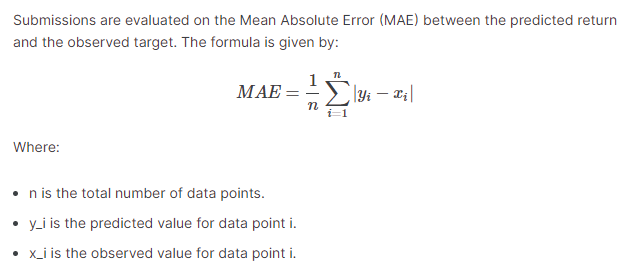

 # Reading the train data: 

In [4]:
train = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/train.csv')
train

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


In [5]:
tester = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv')
tester

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,time_id,row_id,currently_scored
0,0,478,0,3753451.43,-1,0.999875,11548975.43,NaN,NaN,0.999875,22940.00,1.000050,9177.60,1.000000,26290,478_0_0,False
1,1,478,0,985977.11,-1,1.000245,3850033.97,NaN,NaN,0.999940,1967.90,1.000601,19692.00,1.000000,26290,478_0_1,False
2,2,478,0,599128.74,1,1.000584,4359198.25,NaN,NaN,0.999918,4488.22,1.000636,34955.12,1.000000,26290,478_0_2,False
3,3,478,0,2872317.54,-1,0.999802,27129551.64,NaN,NaN,0.999705,16082.04,1.000189,10314.00,1.000000,26290,478_0_3,False
4,4,478,0,740059.14,-1,0.999886,8880890.78,NaN,NaN,0.999720,19012.35,1.000107,7245.60,1.000000,26290,478_0_4,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32995,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,26454,480_540_195,False
32996,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,26454,480_540_196,False
32997,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,26454,480_540_197,False
32998,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,26454,480_540_198,False


# Colunm Names and what they represent:

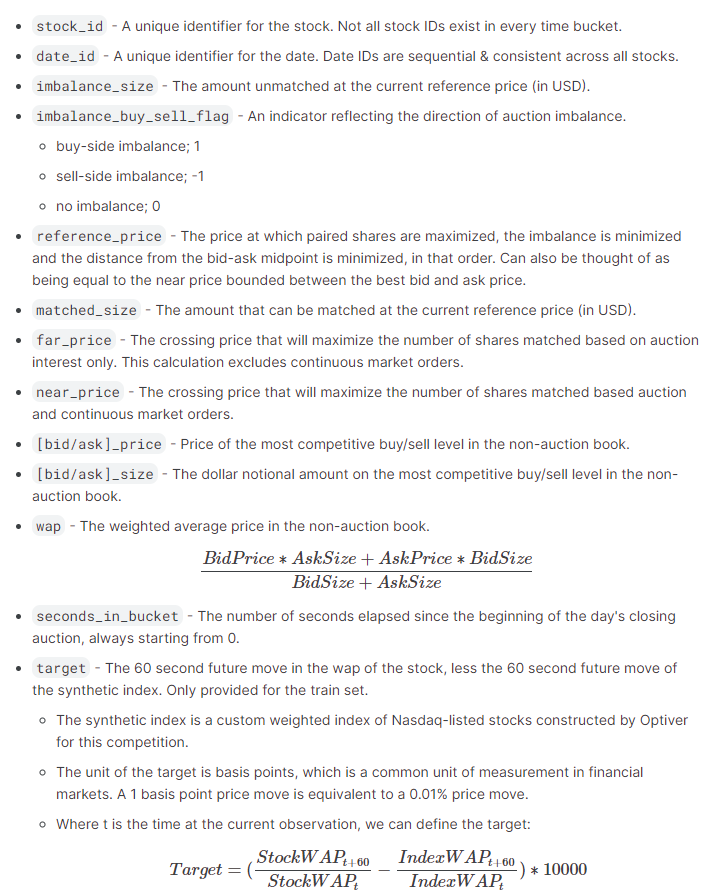

# Understanding the data:



In [6]:
# See if there is any missing data
train.isna().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2894342
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
row_id                           0
dtype: int64

**There seems to be many NaN values in far_price and near_price, so the best approach would be to not use these columns in the model.**

In [7]:
# In case I use it later, I am filling the NaN values with 0 in these columns
train['far_price'].fillna(0, inplace = True)
train['near_price'].fillna(0, inplace = True)
# Drop all rows that still contain NaN
train.dropna(inplace = True)
train.reset_index(inplace = True)

/tmp/ipykernel_18/3427951515.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['far_price'].fillna(0, inplace = True)
/tmp/ipykernel_18/3427951515.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

In [8]:
# Check to see if it works
train.isna().sum()

index                      0
stock_id                   0
date_id                    0
seconds_in_bucket          0
imbalance_size             0
imbalance_buy_sell_flag    0
reference_price            0
matched_size               0
far_price                  0
near_price                 0
bid_price                  0
bid_size                   0
ask_price                  0
ask_size                   0
wap                        0
target                     0
time_id                    0
row_id                     0
dtype: int64

# Correlation Matrix

In [9]:
dependent_columns =  ['stock_id', 'date_id', 'time_id', 'row_id']
correlation_df = train.drop(columns= dependent_columns)

/tmp/ipykernel_18/2538613975.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  corr_matrix = corr_matrix.applymap(lambda x: np.nan if abs(x) < 1e-10 else x)


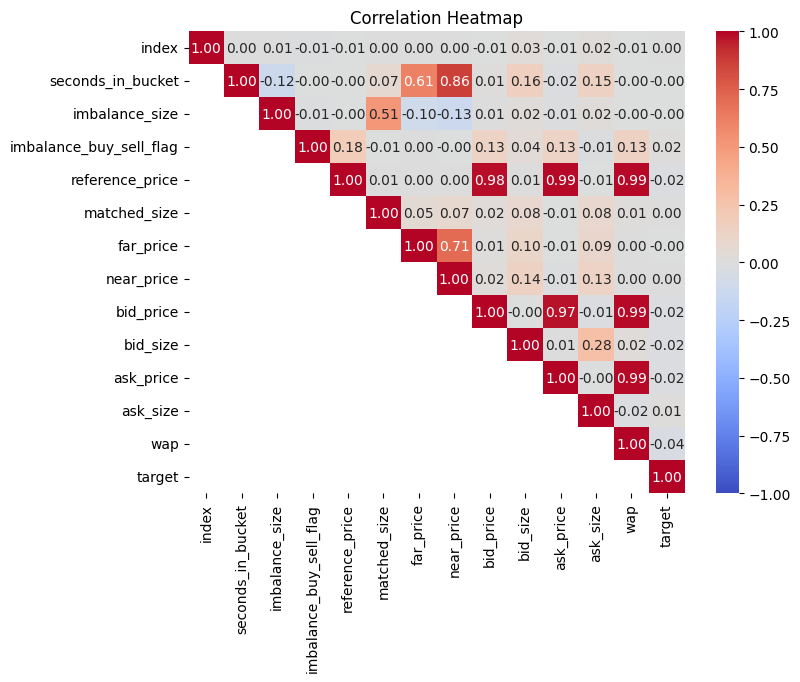

In [10]:
# Calculate the correlation matrix
corr_matrix = correlation_df.corr()
# Create a lower triangular mask
mask = ~np.tri(*corr_matrix.values.shape, k=-1, dtype=bool)

# Apply the mask to set the upper triangle values to NaN
corr_matrix = pd.DataFrame(corr_matrix.values * mask, columns=corr_matrix.columns, index=corr_matrix.index)
# Replace very small values with NaN
corr_matrix = corr_matrix.applymap(lambda x: np.nan if abs(x) < 1e-10 else x)

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

In [11]:
# Feature list to train model. Notice it is excluding far_price, near_price, and all ID columns
feature_list = ['seconds_in_bucket', 'imbalance_size', 'imbalance_buy_sell_flag', 'reference_price',
               'matched_size', 'bid_price', 'ask_price', 'ask_size', 'wap']

In [12]:
# Transform function to transform test set in API to match the input needed for my trained model
def transformdata(tester):
    # Filling the NaN values with 0 in these columns
    tester['far_price'].fillna(0, inplace = True)
    tester['near_price'].fillna(0, inplace = True)
    # Drop all rows still containing NaN values
    tester.dropna(inplace = True)
    tester.reset_index(inplace = True)
    
    return tester

In [13]:
# Dropping "target", the variable I am predicting (refer to column descriptions to see what target is).
X = train.drop('target', axis=1)  # Features
y = train['target']  # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = False)

In [14]:
def model_score(model):
    
    # Predict on the training set
    y_train_pred = model.predict(X_train[feature_list])

    # Predict on the test set
    y_test_pred = model.predict(X_test[feature_list])

    # Calculate Mean Absolute Error (MAE) for training and test sets
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    # Print the results
    print(f'{model} Training Set:')
    print(f'Mean Absolute Error (MAE): {mae_train}')

    print('\n')

    print(f'{model} Test Set:')
    print(f'Mean Absolute Error (MAE): {mae_test}')
    
    print('\n')
    

In [15]:
def fit_models():
    #Initialize and fit LightGBM regressor
    lgbm_model = LGBMRegressor(objective = 'mae', random_state = 55)
    lgbm_model.fit(X_train[feature_list], y_train)
    
    # Initialize and fit Linear Regression
    linear_model = LinearRegression()
    linear_model.fit(X_train[feature_list], y_train)
    
    # Initialize and fit XGBoost Regressor
    xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
    xgb_model.fit(X_train[feature_list], y_train)
    
    # Initialize and fit CatBoost Regressor
    catboost_model = CatBoostRegressor(random_state=42, verbose=0)
    catboost_model.fit(X_train[feature_list], y_train)
    
    return [lgbm_model, linear_model, xgb_model, catboost_model]

In [16]:
# my_Sequential()

In [17]:
# Iterate over model list, sending each model object to a model_score function to see how they perform
'''
my_models = fit_models()
for model in my_models:
    model_score(model)
'''

'\nmy_models = fit_models()\nfor model in my_models:\n    model_score(model)\n'

**Looking at the basic models, without any major transformations, lgbm seems to perform the best (Having the lowest MAE across both train and test sets.**

# Data Preprocessing: Remove Outliers

In [18]:
# Specify the column you want to filter
filter_column = 'target'

# Adjust these percentiles according to your preference
lower_percentile = 5
upper_percentile = 95

# Calculate lower and upper bounds
lower_bound = np.percentile(train[filter_column], lower_percentile)
upper_bound = np.percentile(train[filter_column], upper_percentile)

# Filter the DataFrame based on the bounds
train = train[(train[filter_column] > lower_bound) & (train[filter_column] < upper_bound)]

In [19]:
# Dropping "target", the variable I am predicting (refer to column descriptions to see what target is).
X = train.drop('target', axis=1)  # Features
y = train['target']  # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = False)

In [20]:
# my_Sequential()

In [21]:
# Iterate over model list, sending each model object to a model_score function to see how they perform
'''
my_models = fit_models()
for model in my_models:
    model_score(model)
'''

'\nmy_models = fit_models()\nfor model in my_models:\n    model_score(model)\n'

**Significant improvement by removing ouutliers. From MAE of 6.00 to 4.49. Moreover, CatBoost seemed to work slightly better (by .01) compared to LightGBM, or LGBM**

# Cross Validation using K-fold:

K-fold cross-validation partitions the dataset into K subsets, where each subset serves as a validation set once while the remaining subsets are used for training. The model is trained and evaluated K times, producing K performance metrics that are averaged to estimate the model's generalization error. This technique aids in assessing the model's stability, guiding hyperparameter tuning, and understanding the bias-variance trade-off. Common choices for K include 5-fold and 10-fold cross-validation, offering robust evaluation and validation of machine learning models.

In [22]:
def cv_Kfolds(model):
    
    print(model)
    # Define the range of k values
    k_range = range(5, 10)

    for k in k_range:
        print(f'Number of Folds: {k}')

        # Initialize KFold with k folds
        kf = KFold(n_splits=k, shuffle=False)

        # Lists to store MAE results for each fold
        train_mae_list = []
        test_mae_list = []

        # Perform k-fold cross-validation
        for train_index, test_index in kf.split(X_train):
            X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
            y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

            # Train the model on the training fold
            model.fit(X_train_fold[feature_list], y_train_fold)

            # Predict on the training fold
            y_train_fold_pred = model.predict(X_train_fold[feature_list])

            # Predict on the validation fold
            y_val_fold_pred = model.predict(X_val_fold[feature_list])

            # Calculate MAE for the training and validation folds
            mae_train_fold = mean_absolute_error(y_train_fold, y_train_fold_pred)
            mae_val_fold = mean_absolute_error(y_val_fold, y_val_fold_pred)

            train_mae_list.append(mae_train_fold)
            test_mae_list.append(mae_val_fold)

        # Calculate and print the average MAE across folds
        avg_train_mae = np.mean(train_mae_list)
        avg_test_mae = np.mean(test_mae_list)

        print(f'Average Training MAE: {avg_train_mae}')
        print(f'Average Validation MAE: {avg_test_mae}')
        print('\n' + '='*40 + '\n')

In [23]:
from keras.callbacks import ModelCheckpoint
def cv_folds_Sequential():
    
    filepath = "best_model.keras"
    checkpoint = ModelCheckpoint(filepath, monitor='val_mae', verbose=1, save_best_only=True, mode='min')
    # Define the range of k values
    k_range = range(5, 10)
    
    # Define the neural network model
    model = Sequential()
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1))

    # Compile model with MAE as the loss and use Adam optimizer
    model.compile(
        loss='mae',  # Use 'mae' for Mean Absolute Error
        optimizer=Adam(),
        metrics=['mae']  # Monitor MAE during training
    )

    for k in k_range:
        print(f'Number of Folds: {k}')

        # Initialize KFold with k folds
        kf = KFold(n_splits=k, shuffle=False)

        # Lists to store MAE results for each fold
        train_mae_list = []
        test_mae_list = []

        # Perform k-fold cross-validation
        for train_index, test_index in kf.split(X_train):
            X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
            y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

             # Train the model
            history = model.fit(
                X_train_fold[feature_list],
                y_train_fold,
                epochs=10,
                batch_size=1024,
                validation_data=(X_val_fold[feature_list], y_val_fold),
                verbose=1,
                callbacks=[checkpoint]
            )

            # Extract training and validation MAE from history
            training_mae = history.history['mae'][-1]
            validation_mae = history.history['val_mae'][-1]

In [24]:
# cv_folds_Sequential()

In [25]:
'''
for model in my_models:
    cv_Kfolds(model)
'''

'\nfor model in my_models:\n    cv_Kfolds(model)\n'

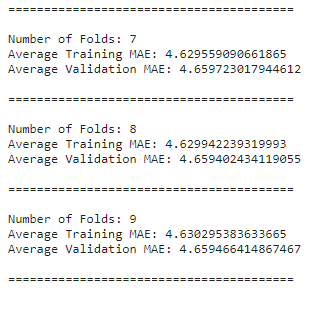

**The score seemed to get worse by using kfolds, no matter the algorithm, so let us still stick with the Outlier Removal**

# Hyperparameter tuning using Grid Search


Grid search is a hyperparameter tuning technique that systematically explores a predefined grid of hyperparameter values to find the optimal combination that maximizes the model's performance. It works by evaluating the model's performance using cross-validation for each combination of hyperparameters in the grid. The combination with the highest cross-validation score is selected as the best set of hyperparameters. Grid search is a powerful tool for fine-tuning machine learning models and optimizing their performance.

In [26]:
from sklearn.model_selection import RandomizedSearchCV

def my_gridSearch(model):
    
    # Define the parameter grid for grid search
    param_grid = {
        'boosting': ['rf'],
        'n_estimators': [100, 500],
        'num_leaves': [31, 62],
        'objective': ['mae'],
        'bagging_freq': [5, 10],  # Specify bagging frequency
        'bagging_fraction': [0.6, 0.8],  # Specify bagging fraction
        'feature_fraction': [0.6, 0.8]  # Specify feature fraction
    }

    # Initialize RandomizedSearchCV with the LightGBM model, parameter grid, and scoring metric
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=2,  # Number of random parameter combinations to try
        scoring='neg_mean_absolute_error',  # Set the metric to focus on reducing MAE
        n_jobs=-1  # Utilize all available CPU cores for parallel computation
    )

    # Fit the randomized search to the data
    random_search.fit(X_train[feature_list], y_train)

    # Get the best parameters from the randomized search
    best_params = random_search.best_params_

    # Use the best parameters to train the final model
    best_model = model(**best_params)
    best_model.fit(X_train[feature_list], y_train)

    # Predict on the training set
    y_train_pred = best_model.predict(X_train[feature_list])

    # Predict on the test set
    y_test_pred = best_model.predict(X_test[feature_list])

    # Calculate Mean Absolute Error (MAE) for training and test sets
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    # Print the results
    print(f'{model} Best Parameters: {best_params}')

    print(f'\nTraining Set:')
    print(f'{model} Mean Absolute Error (MAE): {mae_train}')

    print('\n')

    print(f'Test Set:')
    print(f'{model} Mean Absolute Error (MAE): {mae_test}')

In [27]:
'''
for model in my_models:
    my_gridSearch(model)
'''

'\nfor model in my_models:\n    my_gridSearch(model)\n'

# Neural Network Approach:

A neural network is a computational model inspired by the human brain, consisting of interconnected artificial neurons organized in layers. During training, the network adjusts its internal parameters to minimize the difference between predicted and actual outputs, enabling it to learn complex patterns from data. Different types of neural networks, such as feedforward, convolutional, recurrent, and autoencoders, are tailored for specific tasks like image recognition, sequence prediction, and data compression.

In [28]:
def my_Sequential():

    from matplotlib.pyplot import plot
    # Set up the directory for saving the best model
    checkpoint_dir = 'keras_models'
    os.makedirs(checkpoint_dir, exist_ok=True)  # Create the directory if it doesn't exist

    # Define the neural network model
    model = Sequential()
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1))

    # Compile model with MAE as the loss and use Adam optimizer
    model.compile(
        loss='mae',  # Use 'mae' for Mean Absolute Error
        optimizer=Adam(),
        metrics=['mae']  # Monitor MAE during training
    )

    # Train the model
    history = model.fit(
        X_train[feature_list],
        y_train,
        epochs=10,
        batch_size=1024,
        validation_data=(X_test[feature_list], y_test),
        verbose=1
    )

    # Extract training and validation MAE from history
    training_mae = history.history['mae'][-1]
    validation_mae = history.history['val_mae'][-1]


    plt.rcParams["figure.figsize"] = (6,5)

    fig, axs = plt.subplots()  # Call subplots() function
    axs.plot(history.history['mae'])
    axs.set_title("NN Train MAE using Sequential")
    axs.set_xlabel('Epoch')
    axs.set_ylabel('MAE')
    axs.set_xlim([0,9])

    plt.show()  # Display the plot

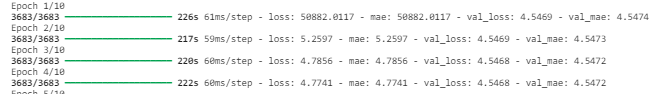

# Feature Engineering

Feature engineering involves selecting, transforming, and creating features to enhance machine learning model performance. It includes processes such as feature selection to identify relevant features and remove irrelevant ones, feature transformation to preprocess data for modeling, and feature creation to generate new informative features. Effective feature engineering can significantly impact model accuracy, interpretability, and generalization to unseen data by providing meaningful representations of the underlying problem. It plays a crucial role in extracting the most predictive information from the available data for better model learning and decision-making.

In [29]:
def feature_Engineer(train, test):
    
    train["volume"] = train.eval("ask_size + bid_size")
    train["mid_price"] = train.eval("(ask_price + bid_price) / 2")
    train["liquidity_imbalance"] = train.eval("(bid_size-ask_size)/(bid_size+ask_size)")
    train["matched_imbalance"] = train.eval("(imbalance_size-matched_size)/(matched_size+imbalance_size)")
    train["size_imbalance"] = train.eval("bid_size / ask_size")
    train["imbalance_momentum"] = train.groupby(['stock_id'])['imbalance_size'].diff(periods=1) / train['matched_size']
    train["price_spread"] = train["ask_price"] - train["bid_price"]
    train["spread_intensity"] = train.groupby(['stock_id'])['price_spread'].diff()
    train['price_pressure'] = train['imbalance_size'] * (train['ask_price'] - train['bid_price'])
    train['market_urgency'] = train['price_spread'] * train['liquidity_imbalance']
    
    test["volume"] = test.eval("ask_size + bid_size")
    test["mid_price"] = test.eval("(ask_price + bid_price) / 2")
    test["liquidity_imbalance"] = test.eval("(bid_size-ask_size)/(bid_size+ask_size)")
    test["matched_imbalance"] = test.eval("(imbalance_size-matched_size)/(matched_size+imbalance_size)")
    test["size_imbalance"] = test.eval("bid_size / ask_size")
    test["imbalance_momentum"] = test.groupby(['stock_id'])['imbalance_size'].diff(periods=1) / test['matched_size']
    test["price_spread"] = test["ask_price"] - test["bid_price"]
    test["spread_intensity"] = test.groupby(['stock_id'])['price_spread'].diff()
    test['price_pressure'] = test['imbalance_size'] * (test['ask_price'] - test['bid_price'])
    test['market_urgency'] = test['price_spread'] * test['liquidity_imbalance']
    
    return train, tester


In [30]:
'''
train, tester = feature_Engineer(train, tester)

train.dropna(axis = 0, inplace = True)
tester.dropna(axis = 0, inplace = True)
# Dropping "target", the variable I am predicting (refer to column descriptions to see what target is).
X = train.drop('target', axis=1)  # Features
y = train['target']  # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = False)

feature_list = ['seconds_in_bucket', 'imbalance_size', 'imbalance_buy_sell_flag',
               'matched_size', 'ask_size', 'wap', 'volume', 'mid_price', 'liquidity_imbalance',
               'matched_imbalance', 'size_imbalance', 'imbalance_momentum', 'price_spread', 'spread_intensity',
               'price_pressure', 'market_urgency']
'''

'\ntrain, tester = feature_Engineer(train, tester)\n\ntrain.dropna(axis = 0, inplace = True)\ntester.dropna(axis = 0, inplace = True)\n# Dropping "target", the variable I am predicting (refer to column descriptions to see what target is).\nX = train.drop(\'target\', axis=1)  # Features\ny = train[\'target\']  # Target variable\n\n# Split the dataset into training and testing sets\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = False)\n\nfeature_list = [\'seconds_in_bucket\', \'imbalance_size\', \'imbalance_buy_sell_flag\',\n               \'matched_size\', \'ask_size\', \'wap\', \'volume\', \'mid_price\', \'liquidity_imbalance\',\n               \'matched_imbalance\', \'size_imbalance\', \'imbalance_momentum\', \'price_spread\', \'spread_intensity\',\n               \'price_pressure\', \'market_urgency\']\n'

In [31]:
X_train[feature_list]

,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,bid_price,ask_price,ask_size,wap
0,0,3.180603e+06,1,0.999812,1.338028e+07,0.999812,1.000026,8493.03,1.000000
1,0,1.666039e+05,-1,0.999896,1.642214e+06,0.999896,1.000660,20605.09,1.000000
2,0,3.028799e+05,-1,0.999561,1.819368e+06,0.999403,1.000298,18995.00,1.000000
3,0,1.191768e+07,-1,1.000171,1.838975e+07,0.999999,1.000214,479032.40,1.000000
4,0,4.475500e+05,-1,0.999532,1.786061e+07,0.999394,1.000016,434.10,1.000000
...,...,...,...,...,...,...,...,...,...
4204237,10,3.665130e+06,-1,0.999709,3.783902e+06,0.999516,0.999806,1036.20,0.999668
4204238,10,1.244471e+08,-1,0.998660,2.363193e+08,0.998356,0.998558,39408.00,0.998481
4204239,10,4.344102e+06,1,0.999119,6.092095e+06,0.997841,1.000068,27387.00,0.998955
4204240,10,1.295147e+06,1,0.999824,6.109571e+06,0.999341,0.999945,8280.00,0.999542


In [32]:
def model_score(model):
    
    # Predict on the training set
    y_train_pred = model.predict(X_train[feature_list])

    # Predict on the test set
    y_test_pred = model.predict(X_test[feature_list])

    # Calculate Mean Absolute Error (MAE) for training and test sets
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    # Print the results
    print(f'{model} Training Set:')
    print(f'Mean Absolute Error (MAE): {mae_train}')

    print('\n')

    print(f'{model} Test Set:')
    print(f'Mean Absolute Error (MAE): {mae_test}')
    
    print('\n')
    
def fit_models():
    #Initialize and fit LightGBM regressor
    lgbm_model = LGBMRegressor(objective = 'mae', random_state = 55)
    lgbm_model.fit(X_train[feature_list], y_train)
    
    # Initialize and fit Linear Regression
    linear_model = LinearRegression()
    linear_model.fit(X_train[feature_list], y_train)
    
    # Initialize and fit XGBoost Regressor
    xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
    xgb_model.fit(X_train[feature_list], y_train)
    
    # Initialize and fit CatBoost Regressor
    catboost_model = CatBoostRegressor(random_state=42, verbose=0)
    catboost_model.fit(X_train[feature_list], y_train)
    
    return [lgbm_model, linear_model, xgb_model, catboost_model]

train.dropna(axis = 0, inplace = True)
tester.dropna(axis = 0, inplace = True)

/tmp/ipykernel_18/316300642.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.dropna(axis = 0, inplace = True)


In [33]:
print(X_train)

           index  stock_id  date_id  seconds_in_bucket  imbalance_size  \
0              0         0        0                  0    3.180603e+06   
1              1         1        0                  0    1.666039e+05   
2              2         2        0                  0    3.028799e+05   
3              3         3        0                  0    1.191768e+07   
4              4         4        0                  0    4.475500e+05   
...          ...       ...      ...                ...             ...   
4204237  4204347       167      387                 10    3.665130e+06   
4204238  4204348       168      387                 10    1.244471e+08   
4204239  4204349       169      387                 10    4.344102e+06   
4204240  4204350       170      387                 10    1.295147e+06   
4204241  4204351       171      387                 10    2.217010e+06   

         imbalance_buy_sell_flag  reference_price  matched_size  far_price  \
0                              1 

In [34]:
'''
my_Sequential()
'''

'\nmy_Sequential()\n'

In [35]:
'''
my_models = fit_models()
for model in my_models:
    model_score(model)
'''

'\nmy_models = fit_models()\nfor model in my_models:\n    model_score(model)\n'

In [36]:
lgbm_model = LGBMRegressor(random_state=42, verbose=0)
lgbm_model.fit(X_train[feature_list], y_train)

LGBMRegressor(random_state=42, verbose=0)

In [37]:
import optiver2023
env = optiver2023.make_env()
iter_test = env.iter_test()

In [38]:
for (test, revealed_targets, sample_prediction) in iter_test:
    X = test[feature_list]
    lgbm_model.predict(X)
    sample_prediction['target'] = lgbm_model.predict(X)
    env.predict(sample_prediction)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
